Using BDTs

In [1]:
from glob import glob
import sys, scipy
from scipy.stats import chi2, poisson
import numpy as np

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 16})

from prettytable import PrettyTable

In [2]:
import ROOT as rt
import root_numpy as rtnp
from utility_func import *

Welcome to JupyROOT 6.10/08


/Users/olmo/programs/root-6.10.08/lib/ROOT.py:318: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  return _orig_ihook( name, *args, **kwds )
Using TensorFlow backend.


In [31]:
import sklearn
print sklearn.__version__
from sklearn.ensemble import GradientBoostingClassifier as GBC
from sklearn.externals import joblib

0.20.0


In [4]:
do_training = 1

# Get the samples

In [5]:
hlf_features = ['HT', 'METp', 'METo', 'MT', 'nJets', 
                'bJets', 'allJetMass', 'LepPt', 'LepEta', 
                'LepIsoCh', 'LepIsoGamma', 'LepIsoNeu', 'LepCharge', 
                'LepIsEle', 'nMu', 'allMuMass', 'allMuPt', 'nEle', 
                'allEleMass', 'allElePt', 'nChHad', 'nNeuHad', 'nPhoton']

active_hlf_features = ['HT', 'allJetMass',
                       'allMuPt', 'allMuMass',
                       'allElePt','allEleMass',
                       'LepPt', 'LepIsoCh', 'LepIsoGamma', 'LepIsoNeu',
                       
                       'METp', 'METo',
                       
                       'MT',
                       
                       'nMu', 'nJets', 'bJets', 'nEle', 
                       
                       'LepCharge','LepIsEle', 
                       
                       'nChHad', 'nNeuHad']

Nf_lognorm = 10
Nf_gauss = 2
Nf_Pgauss = 1
Nf_PDgauss = 4
Nf_binomial = 2
Nf_poisson = 2

sel = []
for a in active_hlf_features:
    for i,f in enumerate(hlf_features):
        if a == f:
            sel.append(i)
# print 'Activated HLF:'
# for n in np.array(hlf_features)[sel]:
#     print '\t', n

In [6]:
data_folder = '../../data/HLF_ONLY/'
TrainSamplesName = ['Wlnu', 'qcd', 'Zll', 'ttbar']
BSM_samples = ['Ato4l', 'Zprime', 'Wprime', 'leptoquark']

N_train_max = int(2e6)

In [7]:
fraction = np.array([0.592, 0.338, 0.067, 0.003])

raw_sample = {}
l = np.zeros(4)
for i,n in enumerate(TrainSamplesName):
    raw_sample[n] = np.load(data_folder+n+'_lepFilter_13TeV_sample.npy')
    l[i] = raw_sample[n].shape[0]
    
i_min = np.argmin(l/fraction)
print 'Limiting stat. sample:', TrainSamplesName[i_min]

N_train = min(0.8*l[i_min], N_train_max)

x_train_s = {}
x_val_s = {}

table = PrettyTable(['Sample', 'Evts tot', 'Train', 'Val'])

for i,n in enumerate(TrainSamplesName):
    N_train_aux = int(N_train * fraction[i]/fraction[i_min])
    x_train_s[n] = raw_sample[n][:N_train_aux, sel]
    x_val_s[n] = raw_sample[n][N_train_aux : int(N_train_aux*1.2) - 1, sel]
    table.add_row([n, raw_sample[n].shape[0], N_train_aux, x_val_s[n].shape[0]])
print table
    
x_train = np.concatenate((x_train_s['Wlnu'], x_train_s['qcd'], x_train_s['Zll'], x_train_s['ttbar']))
x_val = np.concatenate((x_val_s['Wlnu'], x_val_s['qcd'], x_val_s['Zll'], x_val_s['ttbar']))

Limiting stat. sample: qcd
+--------+----------+---------+--------+
| Sample | Evts tot |  Train  |  Val   |
+--------+----------+---------+--------+
|  Wlnu  | 5003421  | 1634053 | 326809 |
|  qcd   | 1166195  |  932956 | 186590 |
|  Zll   | 1777383  |  184935 | 36986  |
| ttbar  | 5001726  |   8280  |  1655  |
+--------+----------+---------+--------+


In [8]:
x_sig = {}
for n in BSM_samples:
    s = np.load(data_folder+n+'_lepFilter_13TeV_sample.npy')
    x_sig[n] = s[:N_train_max, sel]

# Start the Classifier declaration

In [9]:
bdt_clf = {}

### Do the training

In [25]:
n = 'Wprime'
# for n in ['Wprime']:
for n in BSM_samples:  
    bdt_clf[n] = GBC(loss='deviance',
                     learning_rate=0.15,
                     n_estimators=100,
                     min_samples_leaf=3,
                     max_depth=3,
                     max_features=int(x_train.shape[1]*0.5),
                     n_iter_no_change=3,
                     tol=0.0002,
                     validation_fraction=0.2,
                     verbose=1
                    )

    print '\n\n------------------ Training', n, '--------------------'
    aux_x = np.concatenate(( x_train, x_sig[n]))
    aux_y = np.concatenate(( np.zeros(x_train.shape[0]), np.ones(x_sig[n].shape[0]) ))
    
    i_sff = np.random.shuffle(np.arange(aux_x.shape[0]))
    aux_x = aux_x[i_sff:]
    aux_y = np.reshape(aux_y[i_sff], (aux_x.shape[0],))

    bdt_clf[n].fit(X=aux_x, y=aux_y)



------------------ Training Ato4l --------------------
      Iter       Train Loss   Remaining Time 
         1           0.1202            7.42m
         2           0.0997            7.23m
         3           0.0957            7.51m
         4           0.0927            7.36m
         5           0.0886            7.15m
         6           0.0865            7.07m
         7           0.0848            7.01m
         8           0.0826            6.97m
         9           0.0798            6.90m
        10           0.0790            6.85m
        20           0.0666            6.32m
        30           0.0624            5.56m
        40           0.0584            4.77m
        50           0.0556            3.97m
        60           0.0540            3.17m
        70           0.0527            2.38m


------------------ Training Zprime --------------------
      Iter       Train Loss   Remaining Time 
         1           0.1268            7.58m
         2           0.1231 

In [26]:
Eff_SM = 8.06e-06

In [27]:
n = 'Wprime'
p_SM = bdt_clf[n].predict_proba(x_train)[:,1]
p_BSM = bdt_clf[n].predict_proba(x_sig[n])[:,1]

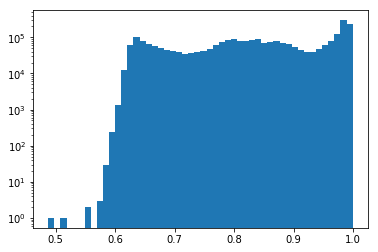

In [28]:
plt.hist(1-p_SM, bins=50)
plt.yscale('log')

In [43]:
def ROC_curve(p_BSM, p_SM, eval_q_SM):
    eval_p = np.percentile(1-p_SM, q=100*eval_q_SM)
    
    out = (1-p_BSM) < np.atleast_2d(eval_p).T
    out = np.sum(out, axis=1)
    q_BSM = out/float(p_BSM.shape[0])
    
    AUC = np.trapz(q_BSM, eval_q_SM)
    
    return q_BSM, AUC

Ato4l: 9.68e-02
Zprime: 1.34e-02
Wprime: 2.15e-05
leptoquark: 4.74e-03


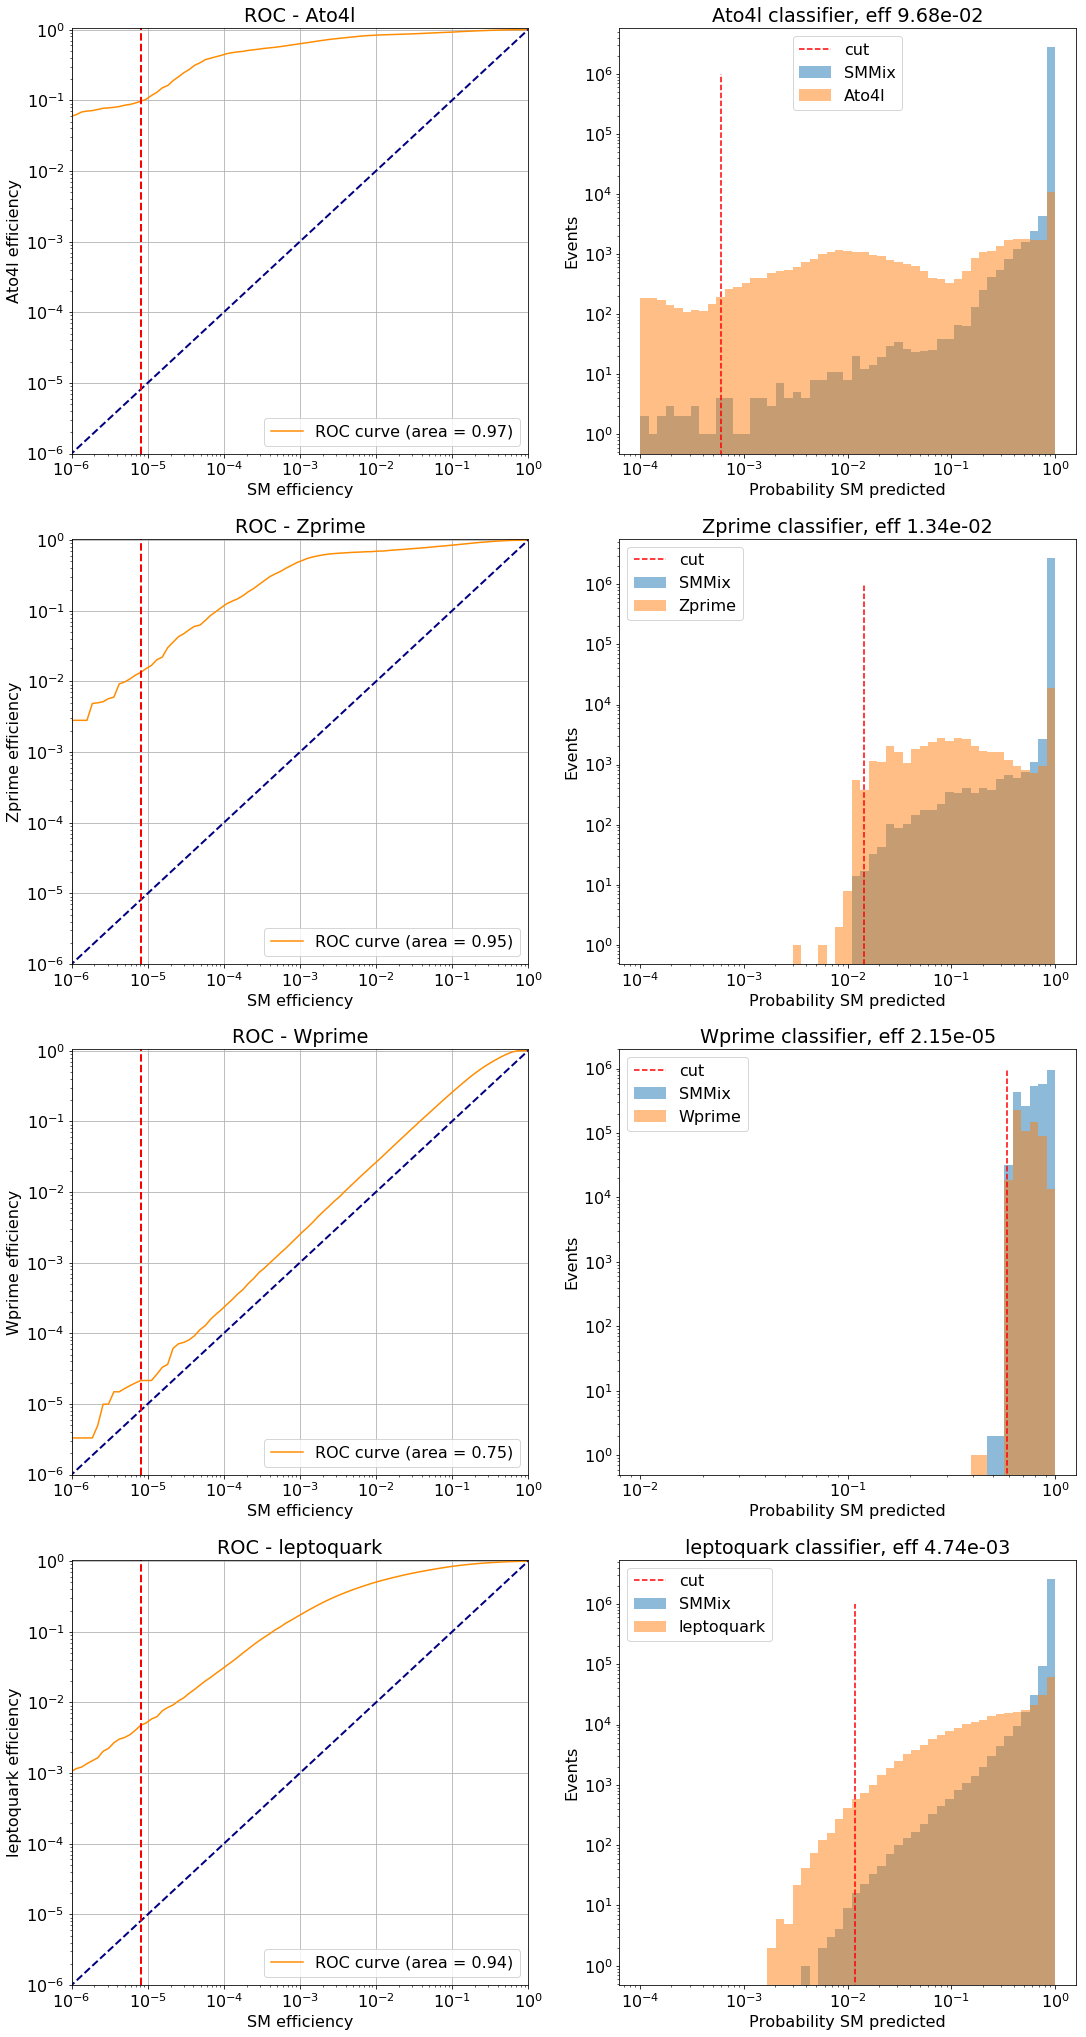

In [44]:
matplotlib.rcParams.update({'font.size': 16})

# f = plt.figure(figsize=(16,8))
# plt.plot(clf[n].training_history['loss'][1:], 'r--', label='loss')
# plt.plot(clf[n].training_history['val_loss'][1:], 'c.', label='val_loss')

# plt.xlabel('Epoch')
# plt.grid()
# plt.legend(loc='best')
# plt.yscale('log')

f, ax_arr = plt.subplots(len(BSM_samples),2 , figsize=(18,36))

for i,n in enumerate(BSM_samples):
    p_SM = bdt_clf[n].predict_proba(x_train)[:,1]
    p_BSM = bdt_clf[n].predict_proba(x_sig[n])[:,1]
    
    # print ROC curve
    q_SM = np.logspace(base=10, start=-7, stop=0, num=100)
    q_BSM, roc_auc = ROC_curve(p_BSM, p_SM, q_SM)
    
    ax_arr[i,0].plot(q_SM, q_BSM, color='darkorange', label='ROC curve (area = {:0.2f})'.format(roc_auc))
    ax_arr[i,0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax_arr[i,0].plot([Eff_SM, Eff_SM], [1e-6, 1.05], color='red', lw=2, linestyle='--')
    ax_arr[i,0].set_xlim([1e-6, 1.0])
    ax_arr[i,0].set_ylim([1e-6, 1.05])
    ax_arr[i,0].set_xlabel('SM efficiency')
    ax_arr[i,0].set_ylabel(n+' efficiency')
    ax_arr[i,0].set_title('ROC - ' + n)
    ax_arr[i,0].legend(loc="lower right")
    ax_arr[i,0].set_yscale('log')
    ax_arr[i,0].set_xscale('log')
    ax_arr[i,0].grid()
    
    

    q = np.percentile(p_SM, 100*(1-Eff_SM))
    eff_BSM = float(np.sum(p_BSM>q))/x_sig[n].shape[0]

    print '{}: {:1.2e}'.format(n, eff_BSM)
    
    bins = np.logspace(base=10, start=-4, stop=0, num=50)
    if n=='Wprime':
        bins = np.logspace(base=10, start=-2, stop=0, num=50)
    ax_arr[i,1].hist(1-p_SM, bins=bins, alpha = 0.5, label='SMMix')
    ax_arr[i,1].hist(1-p_BSM, bins=bins, alpha=0.5, label=n)
    ax_arr[i,1].plot([1-q,1-q], [0,1e6], '--r', label='cut')

    ax_arr[i,1].set_title('{} classifier, eff {:1.2e}'.format(n, eff_BSM))
    ax_arr[i,1].legend(loc='best')
    ax_arr[i,1].set_ylabel('Events')
    ax_arr[i,1].set_xlabel('Probability SM predicted')
    ax_arr[i,1].set_yscale('log')
    ax_arr[i,1].set_xscale('log')

In [45]:
for k,c in bdt_clf.iteritems():
    joblib.dump(c, 'Classifier_'+k+'_v2.pkl')